<a href="https://colab.research.google.com/github/vifirsanova/ml-course/blob/main/tutorials/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Рекуррентные нейросети

### Повторение

**Вопрос**: как работают сверточные нейросети?

- Операция свёртки
- Пулинг
- Feature maps

Почему сверточные нейросети хорошо справляются с задачами в области компьютерного зрения?

Для каких задач в области NLP сверточные нейросети не подходят и почему?

**Почему появляются новые архитекутуры?**

- Можно ли адаптировать сверточные нейросети к задачам машинного перевода и генерации текста?
- Как учитывать порядок слов в последовательности в сверточной нейросети?
- Как моделировать долгосрочные зависимости в сверточной нейросети?

**Сверточные нейросети в задачах на генерацию текста**

- https://arxiv.org/pdf/1702.02390
- Автоэнкордер: энкодер из сверточных слоев + декодер, который выполняет деконвлюцию и использует рекуррентную нейросеть для генерации текста

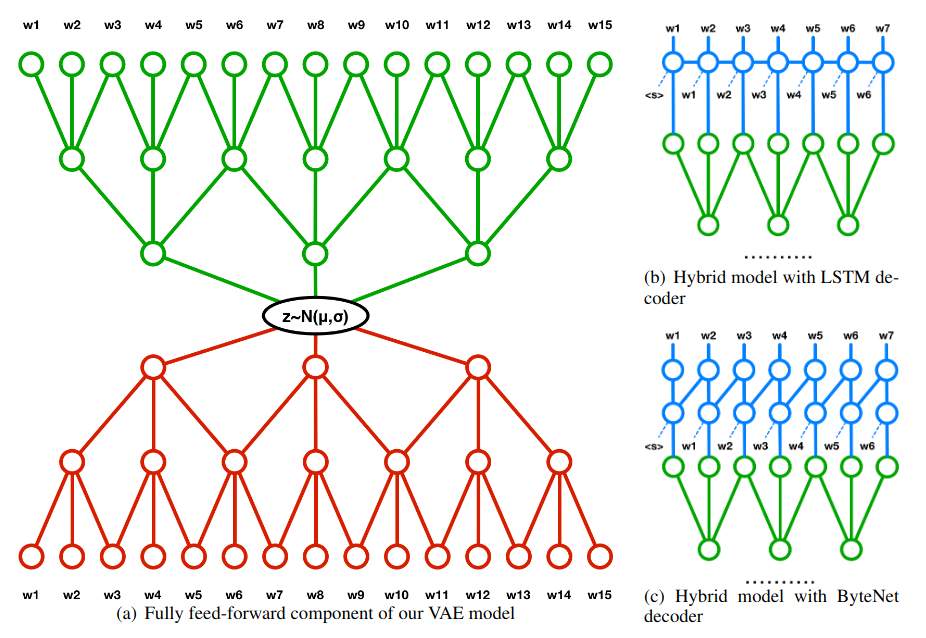

### Интуиция

**Рекуррентная нейросеть**

- Научить модель *запоминать* последовательности, чтобы:

 - вывести информацию о позициях токенов и учитывать порядок расположения токенов

   *Ср. 'A man who hated a snake' vs. 'A snake who hated a man'*

 - натренировать модель кодировать и декодировать длинные последовательности, чтобы выявлять зависимости в сложных рекурсивных конструкциях

    *'A man who hated snakes and never saw snowflakes, who had a little cat and a plenty of hats, was bitten by a mad man on a shiny afternoon.' --> а теперь выполним разметку синтаксиса...*

**Задачи для RNN**

- Генерация текста
- Машинный перевод
- Анализ временных рядов: https://habr.com/ru/companies/otus/articles/732080/
- ELMO: https://github.com/PrashantRanjan09/Elmo-Tutorial

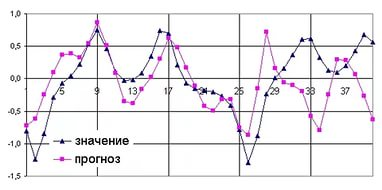

> **Выход RNN на каждом шаге зависит от текущего входа и предыдущего состояния.**

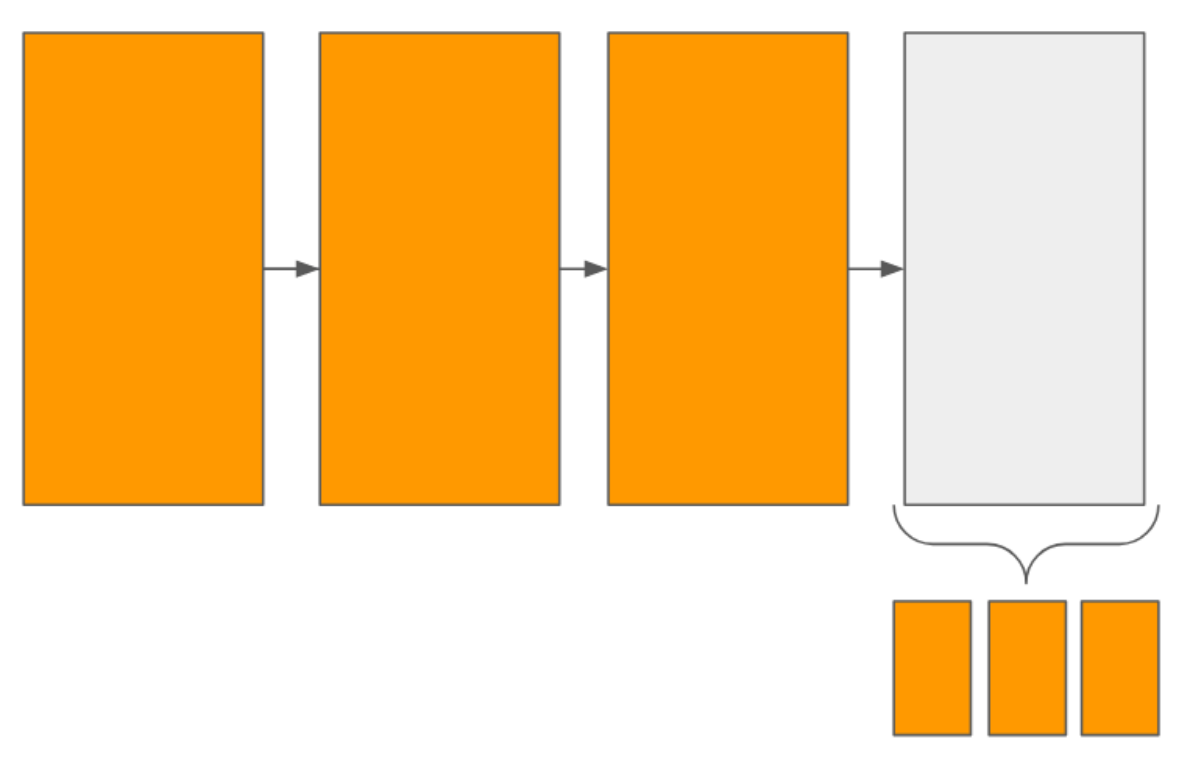

### Ванильная RNN

Что происходит в одной ячейке RNN (скрытое состояние на текущем шаге *t*):

$$ h_t = \sigma( Wx_t + Vh_{t-1}  + b) $$

- $x_t$ - входные данные на шаге *t*

    *Что такое шаг t?*

    *Допустим, мы моделируем предложение 'A cat is on the mat'.*

    *Мы последовательно моделируем следующие зависимости:*

    *P(\<start> | A)*

    *$x_t$ = A*

    *P(\<start> A | cat)*

    *$x_t$ = cat*

    *P(\<start> A cat | is)*

    *$x_t$ = is*

    *P(\<start> A cat is | on)*

    *$x_t$ = on*

    *Этот процесс называется* ***causal language modeling***.

    *Вспомним принцип Маркова: https://en.wikipedia.org/wiki/Markov%27s_principle.*

    *Обратите внимание на способ подготовки данных:*

    ```
    X = [[3000],
        [3000, 3001],
        [3000, 3001, 36],
        [3000, 3001, 36, 133],
        [3000, 3001, 36, 133, 5366],
        [110],
        [110, 30],
        [110, 30, 1274],
        [110, 30, 1274, 336],
        [110, 30, 1274, 336, 17]]

    y = [3001, 36, 133, 5366, 1785, 30, 1274, 336, 17, 3842])
    ```

##### Загрузка библиотек

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

##### Загрузка данных

In [ ]:
!pip install datasets -q

from datasets import load_dataset
dataset = load_dataset("DeveloperOats/Million_News_Headlines")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Нам нужны только тексты заголовков новостей

In [ ]:
dataset['train']['headline_text'][:10]

['aba decides against community broadcasting licence',
 'act fire witnesses must be aware of defamation',
 'a g calls for infrastructure protection summit',
 'air nz staff in aust strike for pay rise',
 'air nz strike to affect australian travellers',
 'ambitious olsson wins triple jump',
 'antic delighted with record breaking barca',
 'aussie qualifier stosur wastes four memphis match',
 'aust addresses un security council over iraq',
 'australia is locked into war timetable opp']

Оставим первые 10000, чтобы упростить задачу

In [ ]:
data = dataset['train']['headline_text'][:10000]

##### Подготовка данных

In [ ]:
# Инициализируем токенизатор
tokenizer = Tokenizer()

# Обучаем токенизатор на заголовках
tokenizer.fit_on_texts(data)

# Преобразуем заголовки в последовательности чисел
sequences = tokenizer.texts_to_sequences(data)

# Создаем входные и выходные данные
X = []
y = []
for seq in sequences:
    for i in range(1, len(seq)):
        X.append(seq[:i])
        y.append(seq[i])

Посмотрим на наши вектора

**Вопрос:** что кодируют эти числа? Какие значения попадают в y, а что хранится в X'ах?

In [ ]:
X[:10], y[:10]

([[3000],
  [3000, 3001],
  [3000, 3001, 36],
  [3000, 3001, 36, 133],
  [3000, 3001, 36, 133, 5366],
  [110],
  [110, 30],
  [110, 30, 1274],
  [110, 30, 1274, 336],
  [110, 30, 1274, 336, 17]],
 [3001, 36, 133, 5366, 1785, 30, 1274, 336, 17, 3842])

##### Создание модели

$$ h_t = \sigma( Wx_t + Vh_{t-1}  + b) $$

- $W$ и $V$ - это обучаемые параметры

  - *Повторение: какие параметры являются обучаемыми, а какие - необучаемыми?*

  - $W$ отвечает на передачу информации от входного слоя к выходному

  - $V$ отвечает за передачу информации внутри скрытых слоев

- $b$ - это bias

  - *Повторение: что такое bias и зачем он используется?*

- $\sigma$ - нелинейность, тип функции, к которой применяются вычисленные параметры


```python
# Определяем класс RNN, который наследуется от snt.RNNCore (базовый класс для RNN-ячеек в Sonnet)
class RNN(snt.RNNCore):
  
  # Конструктор класса, инициализирует параметры RNN
  def __init__(self, hidden_size, activation=tf.tanh, name="vanilla_rnn"):   
    """
    hidden_size: размер скрытого слоя
    activation: тип функции активации
    name: название модели
    """
    # Вызываем конструктор родительского класса (snt.RNNCore)
    super(RNN, self).__init__(name=name)
    
    # Сохраняем размер скрытого состояния (количество нейронов в скрытом слое)
    self._hidden_size = hidden_size
    
    # Сохраняем функцию активации (по умолчанию используется гиперболический тангенс)
    self._activation = activation    
    

  # Метод _build определяет вычисления, которые происходят в RNN на каждом шаге
  def _build(self, input_, prev_state):
    """
    input_: тензор с текущим x_t
    prev_tate: тезор с h_{t-1}
    """
    # Создаем линейный слой для преобразования входных данных в скрытое состояние
    self._in_to_hidden_linear = snt.Linear(
        self._hidden_size, name="in_to_hidden")

    # Создаем линейный слой для преобразования предыдущего скрытого состояния в новое
    self._hidden_to_hidden_linear = snt.Linear(
        self._hidden_size, name="hidden_to_hidden")
    
    # Применяем линейное преобразование к входным данным
    in_to_hidden = self._in_to_hidden_linear(input_)
    
    # Применяем линейное преобразование к предыдущему скрытому состоянию
    hidden_to_hidden = self._hidden_to_hidden_linear(prev_state)
    
    # Складываем результаты и применяем функцию активации
    output = self._activation(in_to_hidden + hidden_to_hidden)

    # Возвращаем выходное значение и новое скрытое состояние (они одинаковы в этой реализации)
    return output, output
  
  # Свойство state_size возвращает размерность скрытого состояния
  @property
  def state_size(self):
    return tf.TensorShape([self._hidden_size])

  # Свойство output_size возвращает размерность выходного значения
  @property
  def output_size(self):
    return tf.TensorShape([self._hidden_size])
```

Метод `_build`:

- Определяет вычисления, которые происходят на каждом шаге RNN.

- Создает два линейных слоя: один для преобразования входных данных в скрытое состояние, другой для преобразования предыдущего скрытого состояния в новое.

- Складывает результаты линейных преобразований и применяет функцию активации.

- Возвращает выходное значение и новое скрытое состояние.

Подробнее: https://colab.research.google.com/github/nassma2019/PracticalSessions/blob/master/rnn/RNN.ipynb

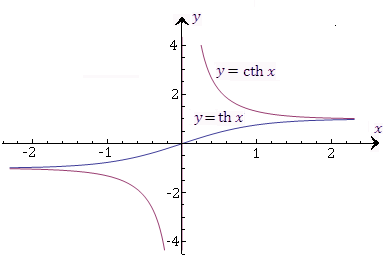

In [ ]:
# Преобразуем списки в массивы numpy
X = np.asarray(X, dtype="object")
y = np.array(y)

# Дополняем последовательности до одинаковой длины
X = pad_sequences(X)

# Преобразуем y в one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=len(tokenizer.word_index) + 1)

##### Обучение модели

In [ ]:
# Создаем модель
model = Sequential()

# Добавляем слой Embedding
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X.shape[1]))

# Добавляем слой LSTM
model.add(LSTM(150, return_sequences=False))

# Добавляем полносвязный слой
model.add(Dense(len(tokenizer.word_index) + 1, activation='softmax'))

# Компилируем модель
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Выводим информацию о модели
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучаем модель
history = model.fit(X, y, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.0423 - loss: 8.1584 - val_accuracy: 0.0439 - val_loss: 7.8368
Epoch 2/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 78s 89ms/step - accuracy: 0.0471 - loss: 7.4274 - val_accuracy: 0.0474 - val_loss: 7.8534
Epoch 3/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - accuracy: 0.0524 - loss: 7.1464 - val_accuracy: 0.0540 - val_loss: 7.8644
Epoch 4/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 83s 89ms/step - accuracy: 0.0623 - loss: 6.8585 - val_accuracy: 0.0620 - val_loss: 7.9295
Epoch 5/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 59s 87ms/step - accuracy: 0.0800 - loss: 6.5175 - val_accuracy: 0.0676 - val_loss: 7.9728
Epoch 6/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 96s 108ms/step - accuracy: 0.0974 - loss: 6.1528 - val_accuracy: 0.0726 - val_loss: 8.0441
Epoch 7/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 68s 88ms/step - accuracy: 0.1165 - loss: 5.7702 - val_accuracy: 0.0741 - val_loss: 8.1589
Epoch 8/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 80s 86ms/step - accuracy: 0.1388 - loss: 5.3986 -

KeyboardInterrupt: 

Обновим саммари модели

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 11, 100)             │       1,005,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 150)                 │         150,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10059)               │       1,518,909 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,026,229 (30.62 MB)

 Trainable params: 2,675,409 (10.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,350,820 (20.41 MB)

Тестируем

In [ ]:
# Функция для генерации текста
def generate_text(seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Генерируем новый заголовок
generated_text = generate_text("Monday", 10, X.shape[1])
print(generated_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Monday draw with strikers says drivers campaign at new train crash


Сохраняем

In [ ]:
# Сохраняем модель
model.save('news_headline_generator.keras')

### Метрики оценки для моделирования языка

Для оценки качества моделирования языка (генерации текста) испольуется метрика **перплексия**

Перплексия - это "инвертированное" правдоподобие последовательности

Допустим, мы обучаем модель для генерации текстов. Чем выше правдоподобие этих текстов (чем сильнее они похожи на тексты из золотой выборки), тем ниже их перплексия

$$\text{PPL}(X) = \exp \left\{ {-\frac{1}{t}\sum_i^t \log p_\theta (x_i|x_{<i}) } \right\}$$

- $\log p_\theta (x_i|x_{<i})$ - правдоподобие i-того токена, обусловленного предшествующими токенами $x_{<i}$ (оцениваем вероятность встречаемости данного токена с предшествующими)

**Интуиция:** оценка способности модели предсказать последовательность и взаимное расположение в контекстах равномерно распределенного набора токенов

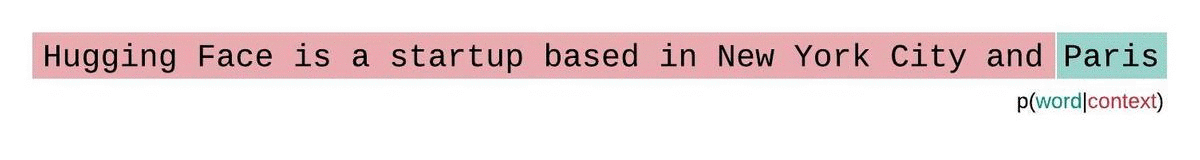

Обычно перплексия считается для заданного контекстного окна, а не для корпуса целиком. Мы добавляем параметр *k*, который считает правдоподобие и перплексию только для токенов в диапазоне $[x_{-1}, x_{k-1}]$:

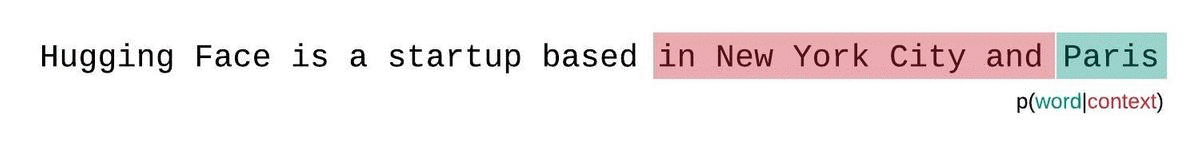

Как это реализовано в HuggingFace: https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/pytorch/perplexity.ipynb

### Методы повышения качества выдач

**Teacher forcing**

На каждом шаге модели подается правильное значение из обучающей последовательности (ground truth), а не то, что предсказала модель

Ground Truth: `["Я", "люблю", "мопсов"]`

Model prediction: `["Я", "мопс"]`.

Здесь вместо использования предсказанного слова модель получает правильное слово "люблю" и пытается предсказать следующее слово - "мопсов" - на основе выдачи из teacher forcing

Статья: https://papers.neurips.cc/paper_files/paper/2016/file/16026d60ff9b54410b3435b403afd226-Paper.pdf

- Чем этот подход отличается от Teacher Forcing?
- Опишите основной принцип предложенного в статье подхода.
- Какие недостатки есть у подхода Professor Forcing?

**Взрывающийся и исчезающий градиент**

Эти проблемы возникают на этапе **обратного распространения ошибки**. Исчезающий градиент возникает, когда градиенты, передаваемые обратно через слои сети во время обратного распространения, становятся чрезвычайно малыми. В результате веса сети почти не обновляются, и обучение останавливается либо происходит чрезвычайно медленно

Взрывающийся градиент - это обратная ситуация, которая возникает, когда градиенты, передаваемые обратно через слои сети, становятся чрезмерно большими. Это приводит к нестабильности обучения и "взрыву" значений весов

Обе проблемы возникают, когда мы обрабатываем очень длинные последовательности:

- Модель не может улавливать долгосрочные зависимости в данных (они слишком длинные) -> градиент исчезает
- Градиент экспонециально растет с увеличением глубины нейросети -> градиент взрывается

Статья про LSTM: https://ieeexplore.ieee.org/document/8690387

Статья про GRU: https://arxiv.org/abs/1406.1078

- Опишите основной принцип работы этих моделей
- Что такое гейты и как они помогают избежать типичных проблем RNN?
- Насколько надежно использование LSTM / GRU против взрывающегося / исчезающего градиента?